In [1]:
pip install tensorflow keras opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# folder dataset
happy_folder = "dataset/happy/"
angry_folder = "dataset/angry/"
sad_folder = "dataset/sad/"

limit = 250

In [7]:
# load images
images_happy = [cv2.imread(file) for file in glob.glob(happy_folder+"*.jpg")][:limit]
images_angry = [cv2.imread(file) for file in glob.glob(angry_folder+"*.jpg")][:limit]
images_sad = [cv2.imread(file) for file in glob.glob(sad_folder+"*.jpg")][:limit]

In [8]:
# images labeling
labels_happy = [0] * len(images_happy)
labels_angry = [1] * len(images_angry)
labels_sad = [2] * len(images_sad)

In [9]:
# checking data
happy_count = len(images_happy)
happy_count

250

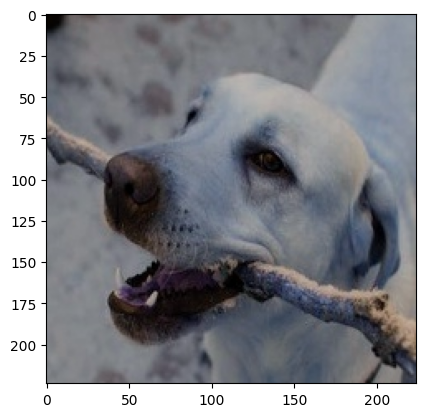

In [10]:
img = np.asarray(images_happy[99])
imgplot = plt.imshow(img)

In [11]:
# resize images to 64x64

common_size = (224,224)
images_happy = [cv2.resize(image, common_size) for image in images_happy]
images_angry = [cv2.resize(image, common_size) for image in images_angry]
images_sad = [cv2.resize(image, common_size) for image in images_sad]

In [12]:
# Concatenate images and labels
X = np.concatenate((images_happy, images_angry, images_sad), axis = 0)
y = np.concatenate((labels_happy, labels_angry, labels_sad), axis = 0)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
X_train.shape

(600, 224, 224, 3)

In [15]:
y_train.shape

(600,)

In [16]:
def initialize_model():

    model = models.Sequential()

    model.add(layers.Conv2D(64, (3,3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation='relu'))
    
    model.add(layers.Dense(16, activation='relu'))

    model.add(layers.Dense(3, activation='softmax'))
    
    ### Model compilation
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
       
    
    return model

In [17]:
# Training the model

model = initialize_model()

In [18]:
es = EarlyStopping(patience = 10, restore_best_weights= True)

history = model.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 64,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
8/8 [==============================] - 14s 2s/step - loss: 24.3756 - accuracy: 0.3688 - val_loss: 2.8625 - val_accuracy: 0.2667
Epoch 2/25
8/8 [==============================] - 14s 2s/step - loss: 1.4893 - accuracy: 0.3375 - val_loss: 1.1409 - val_accuracy: 0.2500
Epoch 3/25
8/8 [==============================] - 14s 2s/step - loss: 1.1118 - accuracy: 0.3583 - val_loss: 1.0959 - val_accuracy: 0.3667
Epoch 4/25
8/8 [==============================] - 13s 2s/step - loss: 1.1528 - accuracy: 0.3562 - val_loss: 1.1250 - val_accuracy: 0.3667
Epoch 5/25
8/8 [==============================] - 14s 2s/step - loss: 1.1182 - accuracy: 0.3479 - val_loss: 1.1533 - val_accuracy: 0.2667
Epoch 6/25
8/8 [==============================] - 14s 2s/step - loss: 1.0987 - accuracy: 0.3542 - val_loss: 1.1049 - val_accuracy: 0.2500
Epoch 7/25
8/8 [==============================] - 14s 2s/step - loss: 1.0932 - accuracy: 0.3917 - val_loss: 1.1023 - val_accuracy: 0.2583
Epoch 8/25
8/8 [=================

In [19]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # ----Loss----
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Validation'], loc= 'best')
    ax[0].grid(axis='x', linewidth=0.5)
    ax[0].grid(axis='y', linewidth=0.5)
    
    # ----Accuracy----
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['Train', 'Validation'], loc= 'best')
    ax[1].grid(axis='x', linewidth=0.5)
    ax[1].grid(axis='y', linewidth=0.5)
    
    if title:
        fig.suptitle(title)

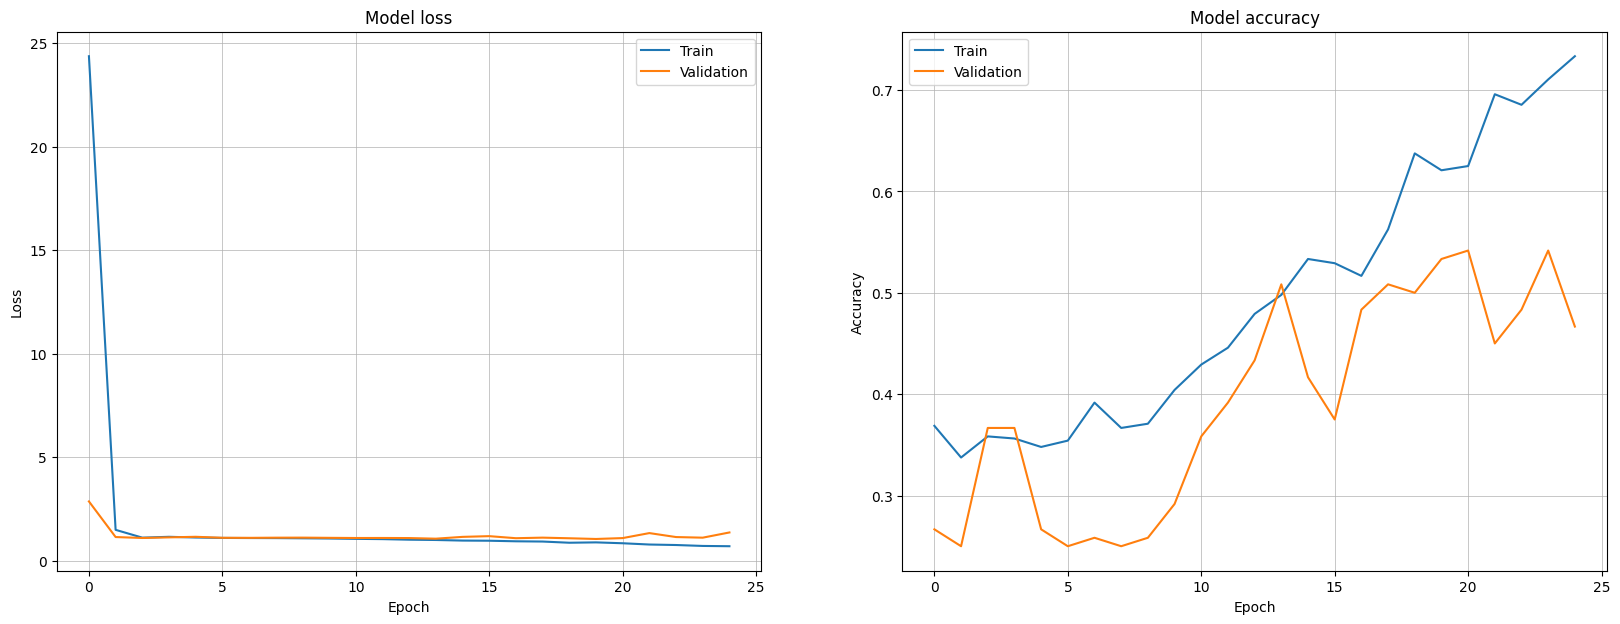

In [20]:
plot_loss_accuracy(history, title=None)

In [21]:
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 213ms/step - loss: 1.3353 - accuracy: 0.4667


In [22]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 46.67 %


# VCG16 Model

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

In [24]:
def initialize_vgg16_model():
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained VGG16 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

    # Add the pre-trained VGG16 model as the first layer
    model.add(base_model)


    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [25]:
model = initialize_vgg16_model()

In [26]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
15/15 [==============================] - 69s 5s/step - loss: 59.5490 - accuracy: 0.4875 - val_loss: 17.5106 - val_accuracy: 0.7000
Epoch 2/25
15/15 [==============================] - 70s 5s/step - loss: 7.8762 - accuracy: 0.8271 - val_loss: 5.9758 - val_accuracy: 0.7583
Epoch 3/25
15/15 [==============================] - 71s 5s/step - loss: 1.7936 - accuracy: 0.9396 - val_loss: 4.0544 - val_accuracy: 0.8250
Epoch 4/25
15/15 [==============================] - 72s 5s/step - loss: 0.4742 - accuracy: 0.9729 - val_loss: 3.5846 - val_accuracy: 0.8500
Epoch 5/25
15/15 [==============================] - 71s 5s/step - loss: 0.4771 - accuracy: 0.9583 - val_loss: 3.1812 - val_accuracy: 0.8583
Epoch 6/25
15/15 [==============================] - 70s 5s/step - loss: 0.1912 - accuracy: 0.9771 - val_loss: 5.3209 - val_accuracy: 0.8000
Epoch 7/25
15/15 [==============================] - 72s 5s/step - loss: 0.1549 - accuracy: 0.9896 - val_loss: 3.4405 - val_accuracy: 0.8417
Epoch 8/25
15/15 [

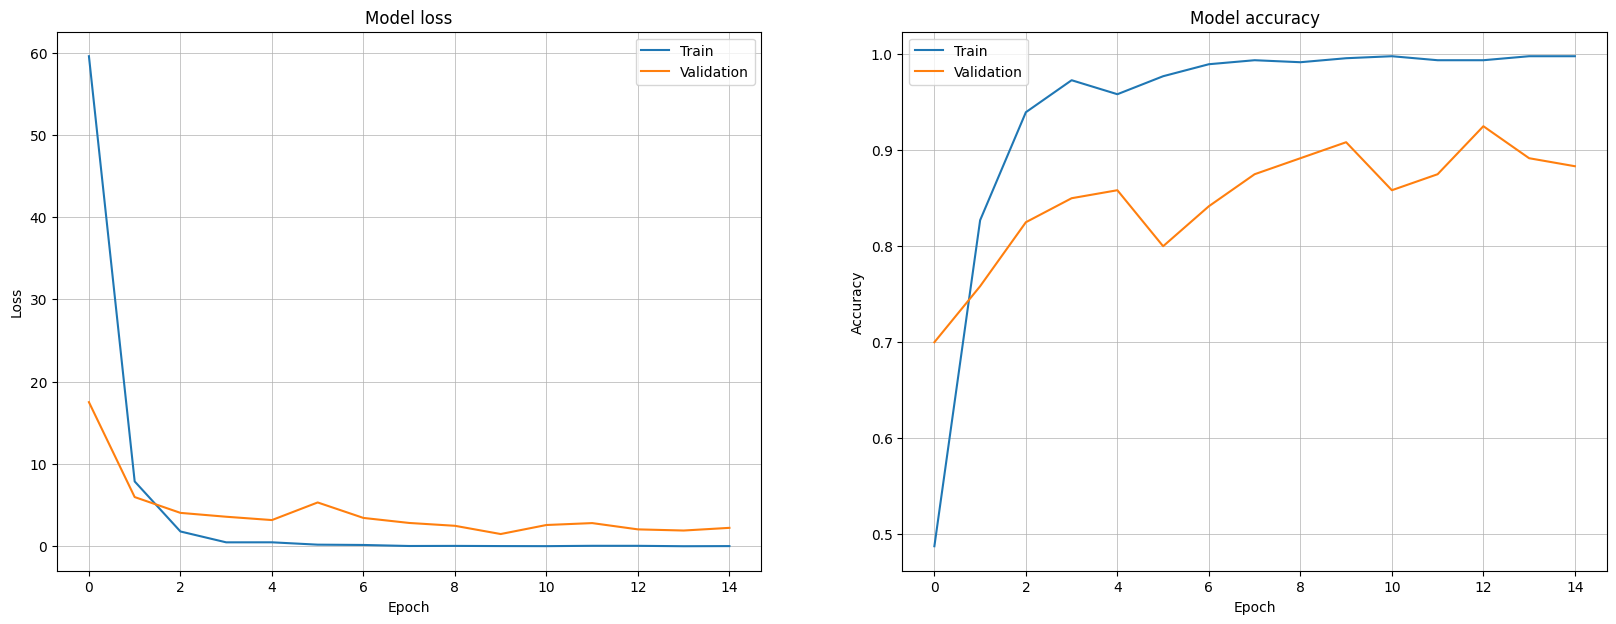

In [27]:
plot_loss_accuracy(history, title=None)

In [28]:
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 14s 3s/step - loss: 4.1707 - accuracy: 0.8000


In [29]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 80.0 %


# VCG19 Model

In [32]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19

In [36]:
def initialize_vgg19_model():
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the pre-trained VGG19 model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a Sequential model
    model = Sequential()

     # Add data augmentation layers
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomZoom(0.1))
    model.add(layers.RandomTranslation(0.2, 0.2))
    model.add(layers.RandomRotation(0.1))

    # Add the pre-trained VGG16 model as the first layer
    model.add(base_model)

    # Add custom layers
    # model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.L1L2(0.01, 0.1)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    # Build the model
    model.build((None, 224, 224, 3))

    # Model compilation
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [37]:
model = initialize_vgg19_model()

In [38]:
es = EarlyStopping(patience = 5, restore_best_weights= True)

history = model.fit(X_train, y_train,
                    epochs = 25,
                    batch_size = 32,
                    validation_split = 0.2,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/25
15/15 [==============================] - 80s 5s/step - loss: 15.8941 - accuracy: 0.4125 - val_loss: 5.4129 - val_accuracy: 0.5083
Epoch 2/25
15/15 [==============================] - 84s 6s/step - loss: 8.0797 - accuracy: 0.4542 - val_loss: 3.3527 - val_accuracy: 0.5500
Epoch 3/25
15/15 [==============================] - 86s 6s/step - loss: 4.4949 - accuracy: 0.5125 - val_loss: 2.7651 - val_accuracy: 0.5667
Epoch 4/25
15/15 [==============================] - 88s 6s/step - loss: 3.1884 - accuracy: 0.4625 - val_loss: 1.2848 - val_accuracy: 0.5167
Epoch 5/25
15/15 [==============================] - 93s 6s/step - loss: 1.5793 - accuracy: 0.3812 - val_loss: 1.1153 - val_accuracy: 0.4500
Epoch 6/25
15/15 [==============================] - 92s 6s/step - loss: 1.1959 - accuracy: 0.3667 - val_loss: 0.9882 - val_accuracy: 0.4333
Epoch 7/25
15/15 [==============================] - 90s 6s/step - loss: 1.1387 - accuracy: 0.3417 - val_loss: 0.9934 - val_accuracy: 0.4667
Epoch 8/25
15/15 [=

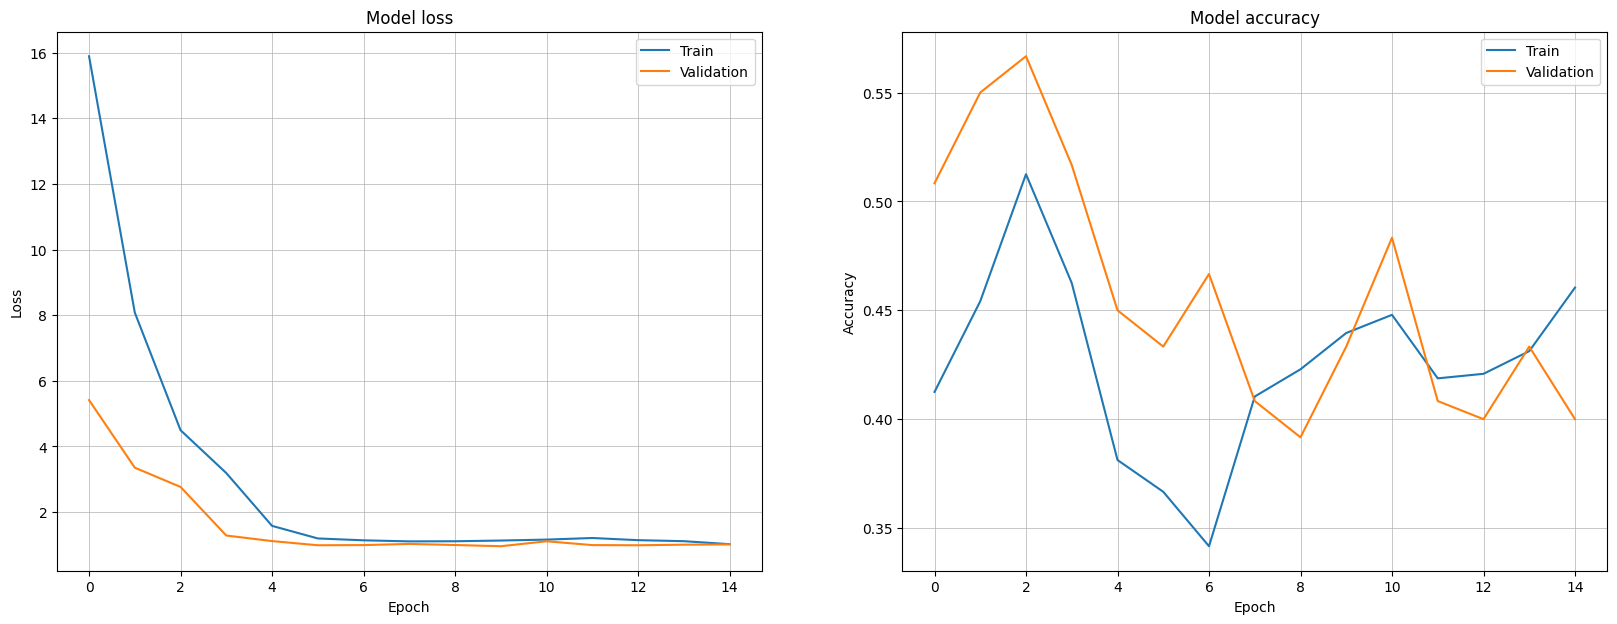

In [39]:
plot_loss_accuracy(history, title=None)

In [40]:
evaluation = model.evaluate(X_test, y_test)

5/5 [==============================] - 25s 5s/step - loss: 1.0398 - accuracy: 0.4067


In [41]:
print(f'Model accuracy is {round(evaluation[1]*100,2)} %')

Model accuracy is 40.67 %
